가설: 인구대비 지하철 이용률이 높은 도시는 인구대비  사고 발생률이 낮다

In [0]:
from datascience import *
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
# 일단 import 
%matplotlib inline  
#matplotlib에서 한글 사용법 출처
#https://colab.research.google.com/github/nicewook/datascience_exercise/blob/master/korean_font_on_matplotlib.ipynb#scrollTo=xB0e99-Wy6kO
import matplotlib.font_manager as fm  # 폰트 관련 용도

In [5]:
#https://www.data.go.kr/dataset/3038489/fileData.do
#2017년_시도_시군구별_연령층별_교통사고.csv
#해당 데이터를 시도별 교통사고 발생건수로 사용하기 위해 시도를 기준으로 groupby한 후 
#군구별로 구분 되어 있는 데이터를 sum으로 합쳐줌
trafficAcident2017=pd.read_csv("20182143-data1.csv",encoding='euc-kr')
trafficAcident2017=trafficAcident2017.groupby("시도").sum()[["발생건수"]]
trafficAcident2017

,발생건수
시도,
강원,8316
경기,50627
경남,11742
경북,13896
광주,7499
대구,12970
대전,7767
부산,11753
서울,38625


In [6]:
#http://kosis.kr/statHtml/statHtml.do?orgId=116&tblId=DT_MLTM_5719&conn_path=I2
#시도별_대중교통이용횟수_1주_20190606154146.csv
#시도별 대중교통 이용하는 사람들중에서 대중교통별 이용하는 인구 퍼센트로 이용하기 위해 따로 데이터를 가공할 필요는 없으나
#데이터 활용의 편의성을 위해 각각의 column을 rename시켜줌
publicTransit2017=pd.read_csv("20182143-data2.csv", encoding="euc-kr")
#encoding="enu-kr"은 유니코드를 한국말로 읽어오기 위해 활용
publicTransit2017=publicTransit2017[["구분(1)","2017","2017.1"]].rename(columns={"구분(1)":"도시","2017":"시내버스","2017.1":"지하철"}).drop([0,1])
publicTransit2017=publicTransit2017.set_index("도시")
publicTransit2017

,시내버스,지하철
도시,,
서울,32.9,67.1
부산,59.2,40.8
인천,54.1,45.9
대구,62.1,37.9
대전,79.9,20.1
광주,87.0,13.0
울산,98.0,2.0
경기,62.3,37.7
강원,98.2,1.8


In [7]:
#https://www.data.go.kr/dataset/3078089/fileData.do
#대중교통_이용자유형별_이용인원_2017_.csv
#시도별 대중교통 이용 인구수로 이용하기 위해 시도별로 groupby하려 했으나
#,와 -가 문자열로 취급되기 때문에 각각의 column을 다른 배열에 저장하고
#replace를 이용하여 ,는 삭제하고 -는 0으로 처리한 후 sum하여 시도별 대중교통 이용 인구수 데이터를 만들어냄
psUser2017=pd.read_csv("20182143-data3.csv", encoding="euc-kr")
psUser2017=psUser2017.rename(columns={"구분":"도시"}).set_index("도시")

#각각의 column을 다른 배열에 저장
person=psUser2017["일반인"]
child=psUser2017["어린이"]
teenager=psUser2017["청소년"]
senior=psUser2017["기타"]
#rowNum은 다 같으니 일반인으로 count
rowNum=psUser2017["일반인"].count()

#,를 제거한 뒤 저장할 배열 생성
personNoComma=make_array()
teenagerNoComma=make_array()
childNoComma=make_array()
seniorNoComma=make_array()
sum=make_array()

#replace를 이용하여 ,가 발견될 시 이를 제거(rowNum횟수만큼 반복)
for i in np.arange(rowNum):
  personNoComma=np.append(personNoComma, person[i].replace(",",""))
  childNoComma=np.append(childNoComma, child[i].replace(",",""))
  teenagerNoComma=np.append(teenagerNoComma, teenager[i].replace(",",""))
  seniorNoComma=np.append(seniorNoComma,senior[i].replace(",","").replace("-","0"))

#분류된 각각의 column의 값을 sum 배열에 저장(rowNum횟수만큼 반복)
for i in np.arange(rowNum):
  sum=np.append(sum, (int)(personNoComma[i])+(int)(childNoComma[i])+(int)(teenagerNoComma[i])+(int)(seniorNoComma[i]))
  
psUser2017=pd.DataFrame(sum,index=psUser2017.index, columns=["대중교통 이용 인구수"])
psUser2017

,대중교통 이용 인구수
도시,
서울,4423933.0
부산,952394.0
대구,547568.0
인천,775463.0
광주,245970.0
대전,272079.0
울산,152499.0
세종,22677.0
경기,2981638.0


In [8]:
#시도별 지하철 이용 인구수로 이용하기 위해 
#위에서 구한 시도별 대중교통 이용 인구수와 시도별 대중교통별 이용 인구수 퍼센트를 곱함

#인구수는 소수가 아니므로 반올림
pop=make_array()
#join을 이용하여 행을 맞춤
subwayPopulation2017=psUser2017.join(publicTransit2017)
for i in np.arange(rowNum):
  pop=np.append(pop,np.round(subwayPopulation2017["대중교통 이용 인구수"][i]*(float)(subwayPopulation2017["지하철"][i])/100,0))

subwayPopulation2017=pd.DataFrame(pop,index=psUser2017.index, columns=["지하철 이용 인구수"])
subwayPopulation2017

,지하철 이용 인구수
도시,
서울,2968459.0
부산,388577.0
대구,207528.0
인천,355938.0
광주,31976.0
대전,54688.0
울산,3050.0
세종,0.0
경기,1124078.0


In [9]:
#https://www.data.go.kr/dataset/3033255/fileData.do
#201712_201712_주민등록인구및세대현황_월간.csv
#시도별 총인구수로 이용하기 위해 전국에 대한 데이터를 drop시키고
#,는 문자열로 취급되기 때문에 replace를 이용하여 제거해준다
totalPop=make_array()
cityPopulation2017=pd.read_csv("20182143-data4.csv", encoding="euc-kr")
#불필요한 데이터를 drop
cityPopulation2017=cityPopulation2017.drop(0)

#replace를 이용하여 ,제거(rowNum의 횟수만큼)
for i in np.arange(rowNum):
  totalPop=np.append(totalPop, (int)(cityPopulation2017["2017년12월_총인구수"].iloc[i].replace(",","")))

cityPopulation2017=pd.DataFrame(totalPop, index=psUser2017.index, columns=["2017년 총 인구수"])
cityPopulation2017

,2017년 총 인구수
도시,
서울,9857426.0
부산,3470653.0
대구,2475231.0
인천,2948542.0
광주,1463770.0
대전,1502227.0
울산,1165132.0
세종,280100.0
경기,12873895.0


In [10]:
#인구수 대비 지하철 이용비율과 인구수 대비 사고 비율로 이용하기 위해
#join을 이용하여 하나의 dataframe에 데이터를 취합함
proportion2017=cityPopulation2017.join([subwayPopulation2017,trafficAcident2017])
proportion2017["인구 대비 지하철 이용 인구수"]=proportion2017["지하철 이용 인구수"]/proportion2017["2017년 총 인구수"]
proportion2017["인구 대비 사고 발생 건수"]=proportion2017["발생건수"]/proportion2017["2017년 총 인구수"]
proportion2017

,2017년 총 인구수,지하철 이용 인구수,발생건수,인구 대비 지하철 이용 인구수,인구 대비 사고 발생 건수
도시,,,,,
서울,9857426.0,2968459.0,38625,0.301139,0.003918
부산,3470653.0,388577.0,11753,0.111961,0.003386
대구,2475231.0,207528.0,12970,0.083842,0.005240
인천,2948542.0,355938.0,7719,0.120717,0.002618
광주,1463770.0,31976.0,7499,0.021845,0.005123
대전,1502227.0,54688.0,7767,0.036405,0.005170
울산,1165132.0,3050.0,4265,0.002618,0.003661
세종,280100.0,0.0,746,0.000000,0.002663
경기,12873895.0,1124078.0,50627,0.087315,0.003933


In [0]:
#스케일을 맞춰주기 위해 정규화를 진행 (Z=(X-μ)/σ)
def normalization(array):
  retArray=make_array()
  #배열의 크기 
  arrSize=array.size
  #배열의 평균
  arrMean=np.mean(array)
  #배열의 표준편차
  arrStd=np.std(array)
  #배열의 크기만큼 정규화 진행
  for i in np.arange(arrSize):
    z=(array[i]-arrMean)/arrStd
    retArray=np.append(retArray, z)
  return retArray

In [12]:
#스케일을 맞춰주기 위해 정규화를 진행
#음수가 나오면 비교가 어려우므로 최솟값의 절댓값을 더함
temp=proportion2017[["인구 대비 지하철 이용 인구수","인구 대비 사고 발생 건수"]]
popZ=normalization(temp["인구 대비 지하철 이용 인구수"])
popZ=popZ+np.abs(popZ.min())
accidentZ=normalization(temp["인구 대비 사고 발생 건수"])
accidentZ=accidentZ+np.abs(accidentZ.min())

#barh를 편하게 쓰기위해 데이터사이언스의 Table로 만들어 준다.
proportionZ2017=Table().with_columns("도시",psUser2017.index,"2017 인구 대비 지하철 이용 인구수 비율의 Z",popZ, "2017 인구 대비 사고 발생 건수 비율의 Z",accidentZ)
#barh로 표현했을때 눈에 보기 쉽게 sorting을 진행
proportionZ2017=proportionZ2017.sort("2017 인구 대비 지하철 이용 인구수 비율의 Z", descending=True)
proportionZ2017.show()

도시,2017 인구 대비 지하철 이용 인구수 비율의 Z,2017 인구 대비 사고 발생 건수 비율의 Z
서울,3.94916,1.19658
인천,1.58308,0
부산,1.46826,0.707104
경기,1.14505,1.20962
대구,1.09951,2.41257
대전,0.477412,2.34854
광주,0.286476,2.30506
충남,0.0534036,1.6081
경남,0.0374094,0.787297
울산,0.034329,0.959342


In [0]:
#matplotlib에서 한글이 깨져서 따로 다운로드 해서 적용
#한글 나눔 고딕 인스톨
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [14]:
#설치된 나눔폰트들을 출력
sys_font=fm.findSystemFonts()
nanum_font = [f for f in sys_font if 'Nanum' in f]
nanum_font

['/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBrush.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf',
 '/usr/share/fonts/truetype/nanum/NanumPen.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEcoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf',
 '/usr/share/fonts

In [0]:
#이들중 한가지를 선택하여 사용
path = '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
plots.rc('font', family=font_name)
fm._rebuild()

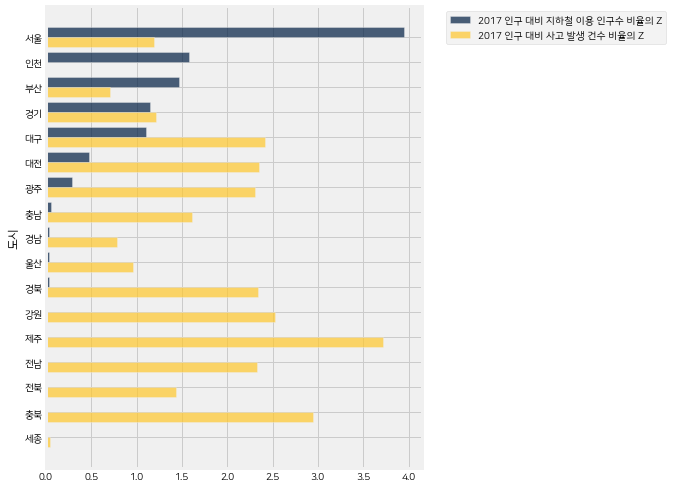

In [16]:
#barh를 이용하여 그래프를 그린다.
proportionZ2017.barh(0)